# Bayesian Neural Networks + SVI inference

In [1]:
#@title Imports
import os
import sys
import json
import copy
import random
import numpy as np
import keras
from tqdm import tqdm

#!pip install torch==1.8.1
import torch
torch.set_default_dtype(torch.float32)
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as nnf
softplus = torch.nn.Softplus()
import torch.optim as torchopt

!pip install pyro-ppl==1.3.0
import pyro
from pyro import poutine
import pyro.distributions as dist
from pyro.optim import Adam
import pyro.optim as pyroopt
from pyro.nn import PyroModule
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from pyro.distributions import Normal, Categorical, OneHotCategorical

import warnings
warnings.filterwarnings('ignore')
#from keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

     |████████████████████████████████| 495 kB 33.6 MB/s 


In [9]:
from keras.datasets import mnist

In [2]:
# set device 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# mount drive folder
from google.colab import drive
drive.mount('/content/drive')

cuda:0
Mounted at /content/drive


In [3]:
path = "/content/drive/My Drive/Copia_di_08_bayesian_neural_networks"

### Load fashion-MNIST dataset

11501568/11490434 [==============================] - 0s 0us/step


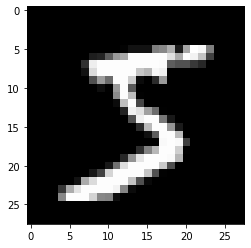

In [10]:
batch_size=128


def load_mnist(n_inputs=60000):
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    output_size = 10

    # subset, select the first n_inputs rows
    x_train = x_train[:n_inputs]
    x_test = x_test[:n_inputs]
    y_train = y_train[:n_inputs]
    y_test = y_test[:n_inputs]

    # one hot encoding
    # One hot encoding is a process by which categorical variables are converted
    # into a form that could be provided to ML algorithms to do a better job in prediction
    y_train = to_categorical(y_train, output_size)
    y_test = to_categorical(y_test, output_size)

    # convert to torch and set dtype
    x_train = torch.from_numpy(x_train.astype('float32'))
    x_test = torch.from_numpy(x_test.astype('float32'))
    y_train = torch.from_numpy(y_train.astype('long'))
    y_test = torch.from_numpy(y_test.astype('long'))

    # convert pixels to 0-1 range
    x_train /= 255
    x_test /= 255

    # expand channels dimension
    ## e.g.    (100, 28, 28) = (n_images, row_pxls, col_pixels) 
    ## becomes (100, 1, 28, 28) = (n_images, n_channels, row_pxls, col_pixels) 
    x_train = x_train.unsqueeze(1)
    x_test = x_test.unsqueeze(1)

    # input/output shapes
    input_shape = x_train[0].shape # = (1, 28, 28)
    
    return x_train, y_train, x_test, y_test, input_shape, output_size

# plot image from mnist
x_train = load_mnist(n_inputs=1)[0]
plt.imshow(x_train[0].squeeze(), cmap='gray')
plt.show()

### Deterministic Neural Network


In [11]:
class DeterministicNetwork(nn.Module):
  
    def __init__(self, input_shape, hidden_size, output_size):

        # initialize nn.Module
        super(DeterministicNetwork, self).__init__()

        input_size = input_shape[0]*input_shape[1]*input_shape[2] # 784
        channels = input_shape[0] # 1 
    
        # architecture
        self.model = nn.Sequential(
                    nn.Conv2d(channels, 32, kernel_size=5),
                    nn.LeakyReLU(),
                    nn.MaxPool2d(kernel_size=2),
                    nn.Conv2d(32, hidden_size, kernel_size=5),
                    nn.LeakyReLU(),
                    nn.MaxPool2d(kernel_size=2, stride=1),
                    nn.Flatten(),
                    nn.Linear(int(hidden_size/(4*4))*input_size, output_size))
    
        self.name = "deterministic_network"

    def forward(self, inputs, *args, **kwargs):
        """ Compute predictions on `inputs`. """
        return self.model(inputs)

    def train(self, x_train, y_train, lr, epochs, device):
        """ Train network. """
        random.seed(0)

        # DataLoader combines a dataset and a sampler, and provides an 
        # iterable over the given dataset
        train_loader = DataLoader(dataset=list(zip(x_train, y_train)), 
                                  batch_size=batch_size, shuffle=False)

        # send network to device
        self.to(device)

        # set optimizer and loss function for training
        optimizer = torchopt.Adam(params=self.parameters(), lr=lr)
        loss_fn = nn.CrossEntropyLoss()
        
        for epoch in range(epochs):
            total_loss = 0.0

            for x_batch, y_batch in train_loader:

                # send data to device
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device).argmax(-1)

                ### loss optimization ###
                outputs = self.forward(x_batch) # forward pass

                # reset gradients w.r.t. network parameters
                optimizer.zero_grad() 

                # loss on predicted labels vs true labels
                loss = loss_fn(outputs, y_batch) 

                # backward pass: computes the derivative of the loss w.r.t.
                # the parameters using backpropagation.
                loss.backward() 

                # update parameters, i.e. take a step based on the gradients 
                # of the parameters.
                optimizer.step() 
                #########################

                # update training loss
                total_loss += loss.data.item() / len(train_loader.dataset)
        
            print(f"\n[Epoch {epoch + 1}]\t loss: {total_loss:.8f}", end="\t")

    def save(self, savedir):
        """ Save network weights. """
        self.to("cpu") # send network to cpu
        os.makedirs(savedir, exist_ok=True)
        torch.save(self.state_dict(), os.path.join(savedir, self.name+"_weights.pt"))
      
    def load(self, savedir, device):
        """ Load network weights. """
        self.load_state_dict(torch.load(os.path.join(savedir, self.name+"_weights.pt")))
        self.to(device)
      
    def evaluate(self, x_test, y_test, device, *args, **kwargs):
        """ Evaluate network on test set. """
        random.seed(0)
        self.to(device)

        test_loader = DataLoader(dataset=list(zip(x_test, y_test)), batch_size=batch_size, shuffle=False)       

        # disable gradients computation
        with torch.no_grad():

            correct_predictions = 0.0

            # compute predictions on mini-batch
            for x_batch, y_batch in test_loader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device).argmax(-1)
                outputs = self(x_batch) # self.forward(x_batch)
                predictions = outputs.argmax(dim=-1)
                correct_predictions += (predictions == y_batch).sum()

            accuracy = 100 * correct_predictions / len(test_loader.dataset)

        return accuracy

In [12]:
x_train, y_train, x_test, y_test, input_shape, output_size = load_mnist(n_inputs=60000)
det_model = DeterministicNetwork(input_shape=input_shape, hidden_size=512, output_size=output_size)

det_model.train(x_train=x_train, y_train=y_train, lr=0.01, epochs=10, device=device)
det_model.save(savedir=path)
det_model.load(savedir=path, device=device)

accuracy = det_model.evaluate(x_test, y_test, device=device)
print("\nTest accuracy: %.2f%%" % (accuracy))


[Epoch 1]	 loss: 0.00254692	
[Epoch 2]	 loss: 0.00052096	
[Epoch 3]	 loss: 0.00038678	
[Epoch 4]	 loss: 0.00074207	
[Epoch 5]	 loss: 0.00044139	
[Epoch 6]	 loss: 0.00045326	
[Epoch 7]	 loss: 0.00126486	
[Epoch 8]	 loss: 0.00121309	
[Epoch 9]	 loss: 0.00057106	
[Epoch 10]	 loss: 0.00063246	
Test accuracy: 98.58%


### Bayesian Neural Network

In [13]:
class BayesianNetwork(PyroModule):

    def __init__(self, input_shape, hidden_size, output_size):
        # initialize PyroModule
        super(BayesianNetwork, self).__init__()

        # BayesianNetwork extends PyroModule class
        self.det_network = DeterministicNetwork(input_shape, hidden_size, output_size)

        self.name = "bayesian_network"
      
    def model(self, x_data, y_data):
        """ Sets prior distributions and conditions on the observations. """
        priors = {}
    
        # set Gaussian priors on the weights of self.det_network
        for key, value in self.det_network.state_dict().items():
            loc = torch.zeros_like(value)
            scale = torch.ones_like(value)
            prior = Normal(loc=loc, scale=scale)
            priors.update({str(key):prior})

        # pyro.random_module places `priors` over the parameters of the nn.Module 
        # self.det_network and returns a distribution, which upon calling 
        # samples a new nn.Module (`lifted_module`)
        lifted_module = pyro.random_module("module", self.det_network, priors)()

        # samples are conditionally independent w.r.t. the observed data
        with pyro.plate("data", len(x_data)):
            out = lifted_module(x_data) # out.shape = (batch_size, num_classes)
            obs = pyro.sample("obs", Categorical(logits=out), obs=y_data) # obs.shape = (batch_size)

    def guide(self, x_data, y_data=None):
        """ Samples from the Variational distribution and returns predictions. """

        # take random samples of det_network's weights from the chosen variational family
        dists = {}
        for key, value in self.det_network.state_dict().items():

            # torch.randn_like(x) builds a random tensor whose shape equals x.shape
            loc = pyro.param(str(f"{key}_loc"), torch.randn_like(value)) 
            scale = pyro.param(str(f"{key}_scale"), torch.randn_like(value))

            # softplus is a smooth approximation to the ReLU function
            # which constraints the scale tensor to positive values
            distr = Normal(loc=loc, scale=softplus(scale))

            # add key-value pair to the samples dictionary
            dists.update({str(key):distr})

        # define a random module from the dictionary of distributions
        lifted_module = pyro.random_module("module", self.det_network, dists)()

        with pyro.plate("data", len(x_data)):

            # compute predictions on `x_data`
            out = lifted_module(x_data)
            preds = nnf.softmax(out, dim=-1)
            return preds
        
    def forward(self, inputs, n_samples=10, sample_idx=None, avg_prediction=True):
        """ Compute predictions on `inputs`. 
        `n_samples` is the number of samples from the posterior distribution.
        If `sample_idx` is provided, it is used as a seed for sampling a single
        model from the Variational family.
        If `avg_prediction` is True, it returns the average prediction on 
        `inputs`, otherwise it returns all predictions 
        """
        if sample_idx:
            # set random seeds for both torch and pyro
            random.seed(sample_idx)
            pyro.set_rng_seed(sample_idx)    

            # sample from the guide() function and evaluate it on `inputs`        
            guide_trace = poutine.trace(self.guide).get_trace(inputs)  

            # get the output prediction from the guide() function
            preds = [guide_trace.nodes['_RETURN']['value']]
        
        else:
            preds = []
            # take multiple samples
            for _ in range(n_samples):         
                guide_trace = poutine.trace(self.guide).get_trace(inputs)  
                preds.append(guide_trace.nodes['_RETURN']['value'])
        
        # list of tensors to tensor
        # preds.shape = (n_samples, batch_size, n_classes)
        preds = torch.stack(preds)

        # return predictions 
        return preds.mean(0) if avg_prediction else preds

    def train(self, x_train, y_train, lr, epochs, device):
        """ Learn network's weights using SVI. """
        random.seed(0)
        pyro.set_rng_seed(0)
        pyro.clear_param_store()

        train_loader = DataLoader(dataset=list(zip(x_train, y_train)), 
                                  batch_size=batch_size, shuffle=False)
 
        # send bayesian network and deterministic network to device
        self.to(device)
        self.det_network.to(device)

        # ELBO loss minimization
        optimizer = pyro.optim.Adam({"lr":lr})
        elbo = TraceMeanField_ELBO()
        svi = SVI(self.model, self.guide, optimizer, loss=elbo)

        for epoch in range(epochs):
            loss = 0.0

            for x_batch, y_batch in train_loader:

                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device).argmax(-1)
                loss += svi.step(x_data=x_batch, y_data=y_batch)

            total_loss = loss / len(train_loader.dataset)
            print(f"Epoch {epoch + 1}]\t loss: {total_loss:.2f}")
          
    def save(self, savedir):
        """ Save posterior weights. """
        os.makedirs(savedir, exist_ok=True)
        fullpath = os.path.join(savedir, self.name+"_weights.pt")
        param_store = pyro.get_param_store()
        param_store.save(fullpath)
        
    def load(self, savedir, device):
        """ Load posterior weights. """
        fullpath = os.path.join(savedir, self.name+"_weights.pt")
        param_store = pyro.get_param_store()
        param_store.load(os.path.join(savedir, fullpath))
        for key, value in param_store.items():
            param_store.replace_param(key, value.to(device), value)

    def evaluate(self, x_test, y_test, device, n_samples=10, avg_prediction=True):
        """ Evaluate network on test set. """
        random.seed(0)
        pyro.set_rng_seed(0)  

        test_loader = DataLoader(dataset=list(zip(x_test, y_test)), 
                                 batch_size=batch_size, shuffle=False)
        
        self.to(device)
        self.det_network.to(device)

        # disable gradients computation
        with torch.no_grad():

            correct_predictions = 0.0

            # compute predictions on mini-batch
            for x_batch, y_batch in test_loader:

                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device).argmax(-1)

                outputs = self.forward(x_batch, n_samples=n_samples, avg_prediction=avg_prediction)
                predictions = outputs.to(device).argmax(-1)
                correct_predictions += (predictions == y_batch).sum().item()

            accuracy = 100 * correct_predictions / len(test_loader.dataset)
        
        return accuracy

In [14]:
x_train, y_train, x_test, y_test, input_shape, output_size = load_mnist(n_inputs=60000)
bay_model = BayesianNetwork(input_shape=input_shape, hidden_size=512, output_size=output_size)

bay_model.train(x_train=x_train, y_train=y_train, lr=0.01, epochs=5, device=device)
bay_model.save(savedir=path)
bay_model.load(savedir=path, device=device)

accuracy = bay_model.evaluate(x_test, y_test, device=device, n_samples=10)
print("\nTest accuracy: %.2f%%" % (accuracy))

Epoch 1]	 loss: 12007.44
Epoch 2]	 loss: 5297.01
Epoch 3]	 loss: 4629.15
Epoch 4]	 loss: 4188.66
Epoch 5]	 loss: 3768.67

Test accuracy: 96.30%


### Adversarial attacks

In [ ]:
def loss_gradient_sign(network, image, label, n_samples=None):
    """ Computes loss gradient sign of `network` w.r.t. `image`. 
    if `n_samples` is not None, returns the expected loss gradient sign.
    """

    if n_samples is None: # deterministic loss gradient 

        # activate gradients computation w.r.t. `image`
        image.requires_grad = True

        output = network.forward(inputs=image) # forward pass
        network.zero_grad() # reset gradients

        loss = torch.nn.CrossEntropyLoss()(output, label).to(dtype=torch.double)
        loss.backward() # backward pass

        gradient_sign = image.grad.data.sign() # get gradients w.r.t. `image`

    else: # Bayesian loss gradient 

        sample_idxs = list(range(n_samples))
        loss_gradients=[]

        for idx in sample_idxs:

            # deepcopy avoids unwanted automatic updates 
            x_copy = copy.deepcopy(image)

            # activate gradients computation w.r.t. `image`
            x_copy.requires_grad = True

            output = network.forward(inputs=x_copy, n_samples=1, sample_idx=idx).to(dtype=torch.double)
            loss = torch.nn.CrossEntropyLoss()(output, label)
            network.zero_grad()
            loss.backward()

            # compute loss gradient sign w.r.t. `sample_idx`
            loss_gradient = x_copy.grad.data[0].sign()
            loss_gradients.append(loss_gradient)

        # expected loss gradient sign
        gradient_sign = torch.stack(loss_gradients).mean(0)

    return gradient_sign

def fgsm_attack(network, image, label, epsilon=0.2, n_samples=None):
    """ Performs FGSM attack on the input `image` using `epsilon` perturbations.
    If `n_samples` is not None performs a Bayesian attack.
    """
    gradient_sign = loss_gradient_sign(network=network, n_samples=n_samples, image=image, label=label)
    perturbed_image = image + epsilon * gradient_sign
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

def attack_network(network, x_test, y_test, device, method="fgsm", hyperparams={}, n_samples=None):
    """ Attacks `network` on `x_test` inputs. 
    `hyperparams` is a dictionary containing the hyperparameters for the attack.
    If `n_samples` is not None performs a Bayesian attack.
    """
    network.to(device)

    adversarial_attacks = []

    # attack mini-batches
    for x, y in zip(x_test, y_test):
        image = x.to(device).unsqueeze(0)
        label = y.argmax(-1).to(device).unsqueeze(0)
        
        if method == "fgsm":
            perturbed_image = fgsm_attack(network=network, image=image, label=label, 
                                          epsilon=hyperparams['epsilon'], n_samples=n_samples)
        else:
            raise NotImplementedError

        adversarial_attacks.append(perturbed_image)

    # list of tensors to tensor
    adversarial_attacks = torch.cat(adversarial_attacks)
    return adversarial_attacks

In [ ]:
# FGSM attack on both networks

x_test, y_test = load_mnist(n_inputs=100)[2:4]

det_adversarial_attacks = attack_network(network=det_model, x_test=x_test, y_test=y_test, 
                                        device=device, method="fgsm", hyperparams={'epsilon':0.2})

bay_adversarial_attacks = attack_network(network=bay_model, x_test=x_test, y_test=y_test, 
                                        device=device, method="fgsm", hyperparams={'epsilon':0.2}, n_samples=10)

In [ ]:
def evaluate_attack(network, x_test, y_test, x_adversarial, device, n_samples=None):

    original_accuracy = network.evaluate(x_test, y_test, device=device, n_samples=n_samples)
    adversarial_accuracy = network.evaluate(x_adversarial, y_test, device=device, n_samples=n_samples)
    print(f"Test accuracy = {original_accuracy}\tAdversarial accuracy = {adversarial_accuracy}")

print("\nDeterministic network")
evaluate_attack(network=det_model, x_test=x_test, y_test=y_test, 
                x_adversarial=det_adversarial_attacks, device=device)

print("\nBayesian network")
evaluate_attack(network=bay_model, x_test=x_test, y_test=y_test, 
                x_adversarial=bay_adversarial_attacks, device=device, 
                n_samples=10)


Deterministic network
Test accuracy = 99.0	Adversarial accuracy = 27.0

Bayesian network
Test accuracy = 98.0	Adversarial accuracy = 98.0
